In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import os
import netCDF4 as nc4
import shutil
import warnings
warnings.filterwarnings('ignore')

In [3]:
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs

### GET OBS DATA

In [4]:
gppfile='/glade/work/rfisher/ILAMB_data/DATA/gpp/FLUXCOM/gpp.nc'
laifile='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/lai/MODIS/lai_0.5x0.5.nc'

In [5]:
ds_gpp = xr.open_dataset(gppfile)
ds_lai = xr.open_dataset(laifile)

ds_gpp=ds_gpp.mean('time')
ds_lai=ds_lai.mean('time')
ds_lai['lat']=ds_lai.lat*-1

In [6]:
ds=ds_gpp

### Get FATES output

#### read fates data

In [74]:
nruns=16
runs=['4x5_out_of_the_box_ann', #0
      'test_SP_cal_4x5', #1
      'test_SP_4x5_rosieLHC_2',  # 2using the SP LHC output
     'test_NOCOMP_4x5_rosieLHC_2',  #3 using the SP LHC output
      'test_SP_4x5_rosieLHC_4',  #4 using the SP LHC output with the right crops and rad model and respiration
      'test_NOCOMP_4x5_rosieLHC_4', #5 using the SP LHC output with the right crops and rad model and respiration 
      'test_NOCOMP_4x5_rosieLHC_5', #6 using the SP LHC output with the right crops and rad model and respiration + manual tuning. overcooks LAI
      'test_SP_4x5_rosieLHC_6', #7 using the SP LHC output with the right crops and rad model and respiration + manual tuning. 
      'test_NOCOMP_4x5_rosieLHC_6', #8 using the SP LHC output with the right crops and rad model and respiration + manual tuning. 
      'test_SP_4x5_rosieLHC_7', #9 using the SP LHC output with the right crops and rad model and respiration + more manual tuning. 
      'test_NOCOMP_4x5_rosieLHC_7', #10 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning. 
      'test_SP_4x5_rosieLHC_8', #11 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning. 
      'test_NOCOMP_4x5_rosieLHC_8', #12 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning. 
      'test_SP_4x5_rosieLHC_9', #13 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning. 
      'test_NOCOMP_4x5_rosieLHC_9', #14 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning.  
      'test_NOCOMP_4x5_rosieLHC_10', #14 using the SP LHC output with the right crops and rad model and respiration + more  manual tuning.  

      'test_CLM60SP_4x5', #6
      'test_SP_4x5_rosieLHC_1']
nchoose = [4,5,13,14]
arcr = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
fatesrun=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
ychoose=[2029, 2006, 2006, 2029,2006,2029,2029,2006,2018,2006,2029,2006,2029,2006,2089,2070]
#
#ychoose=[2029, 2006, 2006, 2029,2006,2029,2029,2006,2018,2006,2009,2006,2009,2006,2009,2079]
names=['cont NOCOMP ','cont SP ',
       'newest calib SP ', 'newest calib NOCOMP ',       
       'crops and rad SP ', 'crops and rad NOCOMP ',
       'crops and rad NOCOMP mancalib ',       
       'crops and rad SP mancalib2','crops and rad NOCOMP mancalib2',
       'crops and rad SP mancalib3','crops and rad NOCOMP mancalib3',
       'crops and rad SP mancalib4','crops and rad NOCOMP mancalib4',
       'crops and rad SP mancalib5','crops and rad NOCOMP mancalib5',
      'crops and rad NOCOMP mancalib6']
        

In [75]:

output_data=[]
for n in range(nruns):
    run=runs[n]
    root='/glade/derecho/scratch/rfisher/'
    if(arcr[n]==1):
        filedir=root+'archive/'+run+'/lnd/hist/'
    else:
        filedir=root+run+'/run/'
    file=run+'.clm2.h0.'+str(ychoose[n])+'-*'
    filename=filedir+file
    print(n,filename)
    outd=xr.open_mfdataset(filename)
    output_data.append(outd)


0 /glade/derecho/scratch/rfisher/archive/4x5_out_of_the_box_ann/lnd/hist/4x5_out_of_the_box_ann.clm2.h0.2029-*
1 /glade/derecho/scratch/rfisher/archive/test_SP_cal_4x5/lnd/hist/test_SP_cal_4x5.clm2.h0.2006-*
2 /glade/derecho/scratch/rfisher/archive/test_SP_4x5_rosieLHC_2/lnd/hist/test_SP_4x5_rosieLHC_2.clm2.h0.2006-*
3 /glade/derecho/scratch/rfisher/archive/test_NOCOMP_4x5_rosieLHC_2/lnd/hist/test_NOCOMP_4x5_rosieLHC_2.clm2.h0.2029-*
4 /glade/derecho/scratch/rfisher/archive/test_SP_4x5_rosieLHC_4/lnd/hist/test_SP_4x5_rosieLHC_4.clm2.h0.2006-*
5 /glade/derecho/scratch/rfisher/archive/test_NOCOMP_4x5_rosieLHC_4/lnd/hist/test_NOCOMP_4x5_rosieLHC_4.clm2.h0.2029-*
6 /glade/derecho/scratch/rfisher/archive/test_NOCOMP_4x5_rosieLHC_5/lnd/hist/test_NOCOMP_4x5_rosieLHC_5.clm2.h0.2029-*
7 /glade/derecho/scratch/rfisher/archive/test_SP_4x5_rosieLHC_6/lnd/hist/test_SP_4x5_rosieLHC_6.clm2.h0.2006-*
8 /glade/derecho/scratch/rfisher/archive/test_NOCOMP_4x5_rosieLHC_6/lnd/hist/test_NOCOMP_4x5_rosieLHC_

#### extract variables

In [76]:
ds_out_gpp_ts=[]
ds_out_lai_ts=[]
ds_out_vegc_ts=[]
for r in range(nruns):
    print('r',r)
    if(fatesrun[r]==1):
        ds_out_gpp_ts.append(output_data[r].FATES_GPP*output_data[r].FATES_FRACTION)
        ds_out_lai_ts.append(output_data[r].FATES_LAI*output_data[r].FATES_FRACTION)
    else:   
        ds_out_gpp_ts.append(output_data[r].FPSN)
        ds_out_lai_ts.append(output_data[r].TLAI)


r 0
r 1
r 2
r 3
r 4
r 5
r 6
r 7
r 8
r 9
r 10
r 11
r 12
r 13
r 14
r 15


In [77]:
ds_out_gpp=[]
ds_out_lai=[]
conv = 3600*24*1000
for r in range(nruns):
    print('r',r)
    ds_out_gpp.append(np.multiply(ds_out_gpp_ts[r].mean('time'),conv))
    ds_out_lai.append(ds_out_lai_ts[r].mean('time'))

r 0
r 1
r 2
r 3
r 4
r 5
r 6
r 7
r 8
r 9
r 10
r 11
r 12
r 13
r 14
r 15


### Make regridder

In [78]:
regridder_gpp = xe.Regridder(ds, ds_out_gpp[0], 'bilinear', periodic=True)

In [79]:
regridder_lai = xe.Regridder(ds, ds_out_lai[0], 'bilinear', periodic=True)

### do regridding of data

In [80]:
gpp45deg = regridder_gpp(ds_gpp['gpp'])
lai45deg = regridder_lai(ds_lai['lai'])
lai45deg['lat']=lai45deg.lat*-1

In [81]:
def make_bias_plot(bias,figname,yminv,ymaxv,n):
    fig = plt.figure(figsize=(10, 5))
    # Create a GeoAxes with the PlateCarree projection
    #ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax = plt.axes(projection=ccrs.Robinson())
    
    # Plot the data on the map
    bias.plot(ax=ax, transform=ccrs.PlateCarree(),cmap='RdYlBu', vmin=yminv, vmax=ymaxv)
    ax.set_title('')
    ax.set_title(figname)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.coastlines()
    
    # Show the plot
    fignamefull='figs/'+figname+'.png'
    plt.savefig(fignamefull,bbox_inches='tight')
    plt.show()

In [82]:
def make_abs_plot(bias,figname,vmn,vmx,n):
    fig = plt.figure(figsize=(10, 5))
    # Create a GeoAxes with the PlateCarree projection
    #ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax = plt.axes(projection=ccrs.Robinson())
    
    # Plot the data on the map
    bias.plot(ax=ax, transform=ccrs.PlateCarree(),cmap='viridis',vmin=vmn,vmax=vmx)
    ax.set_title(figname)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.coastlines()
    
    # Show the plot
    fignamefull='figs/'+figname+'.png'
    plt.savefig(fignamefull,bbox_inches='tight')
    plt.show()


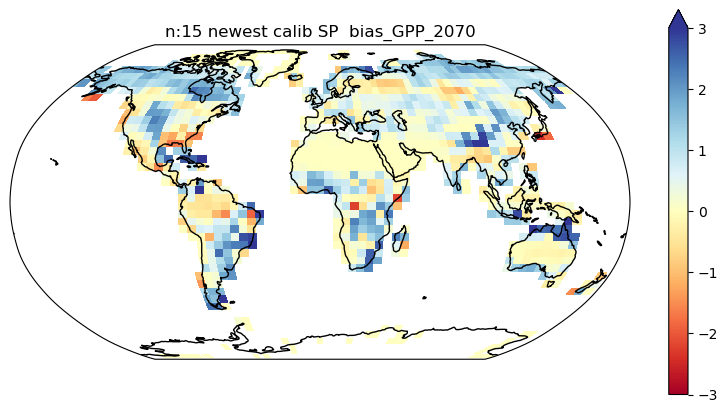

In [83]:
bias = ds_out_gpp[5]-ds_out_gpp[7]
figname='n:'+str(n)+' '+names[2]+' bias_GPP_'+str(ychoose[n])
make_bias_plot(bias,figname,-3,3,n)

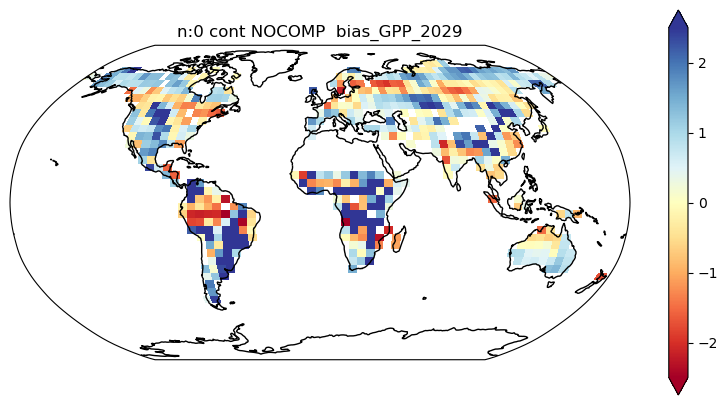

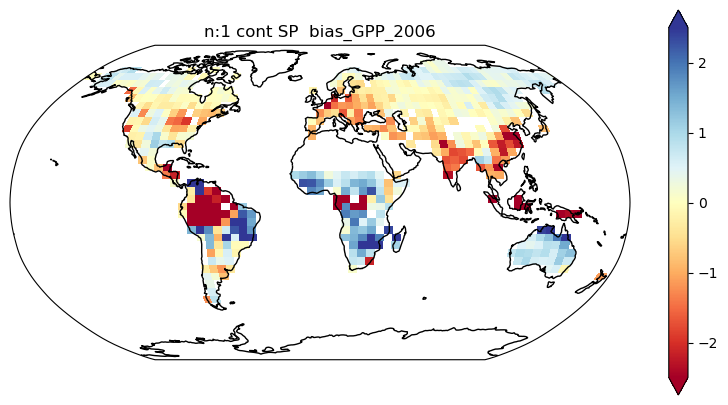

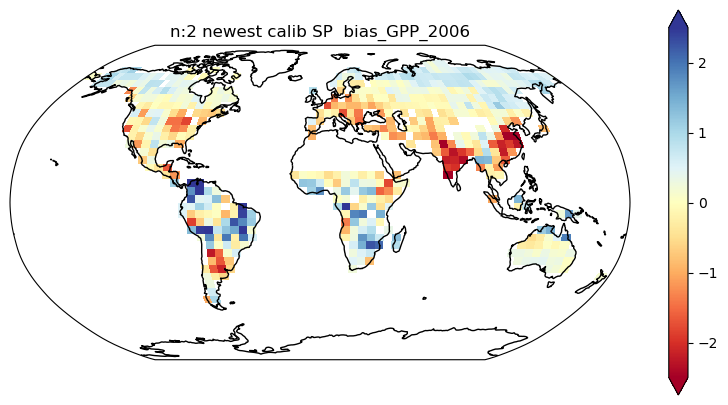

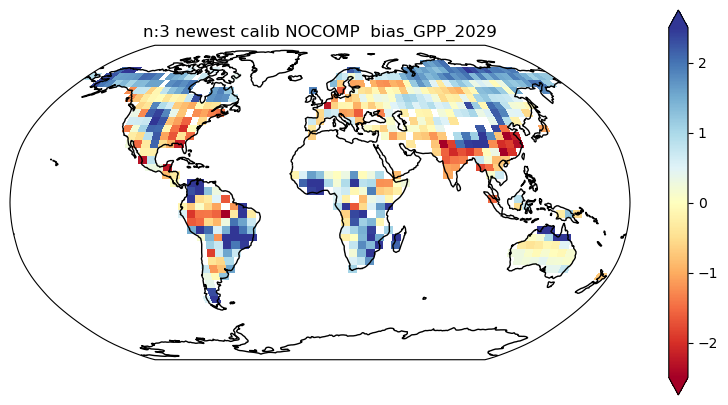

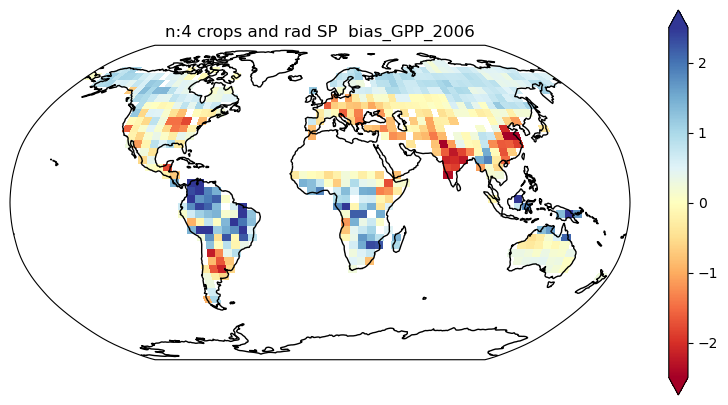

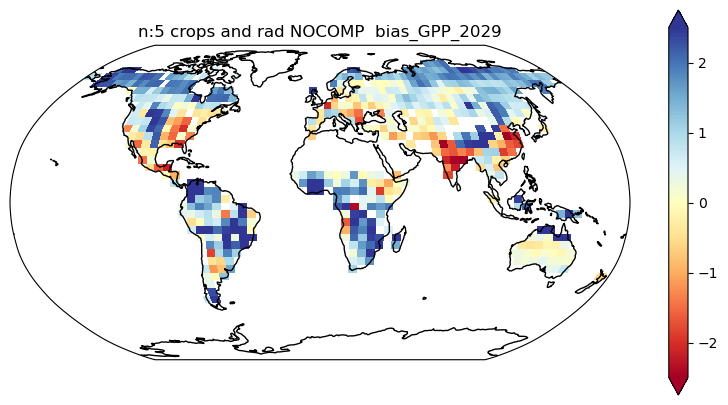

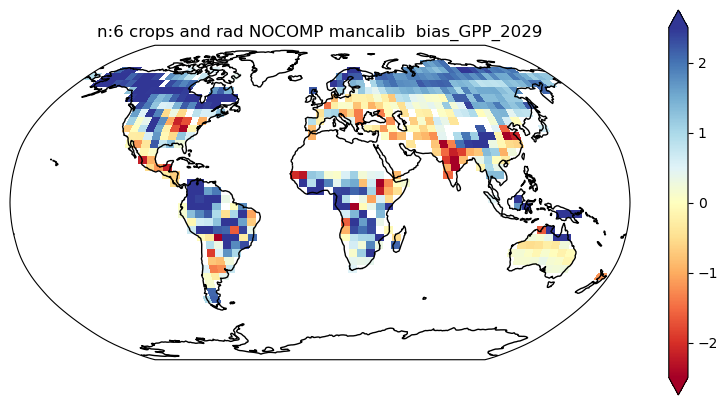

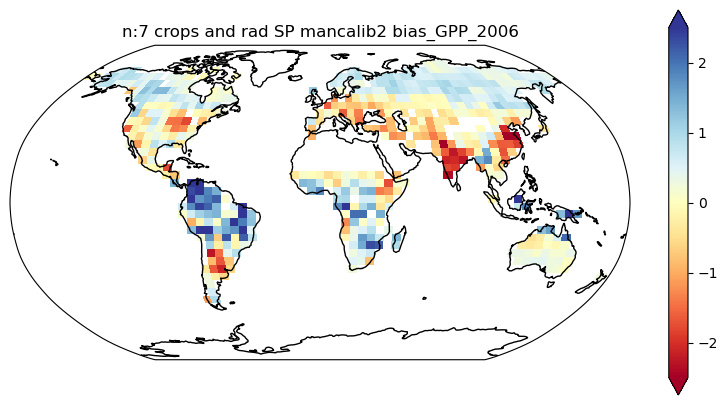

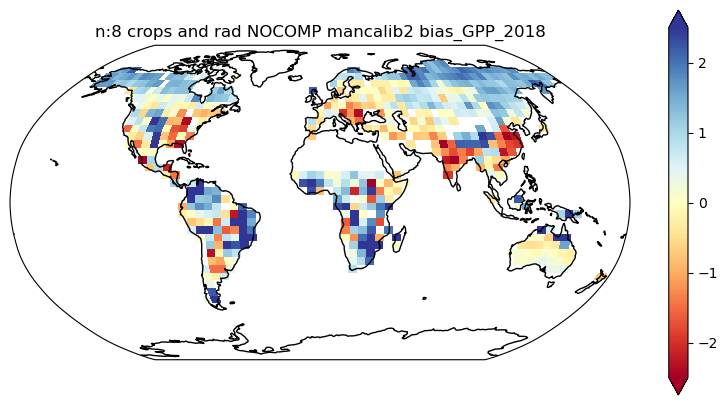

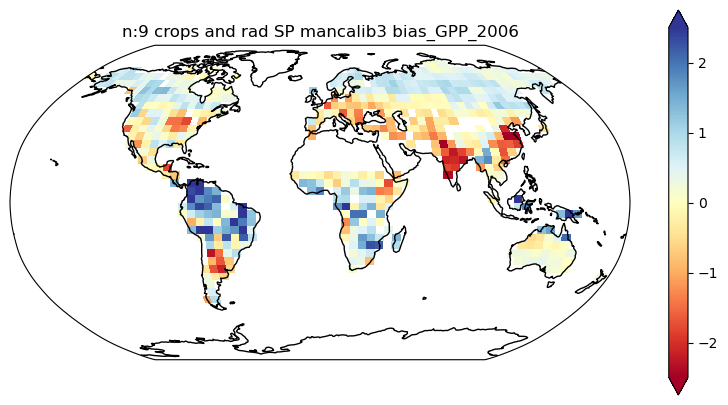

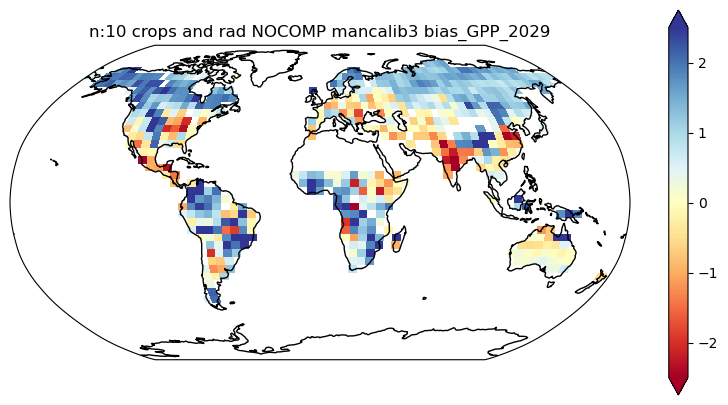

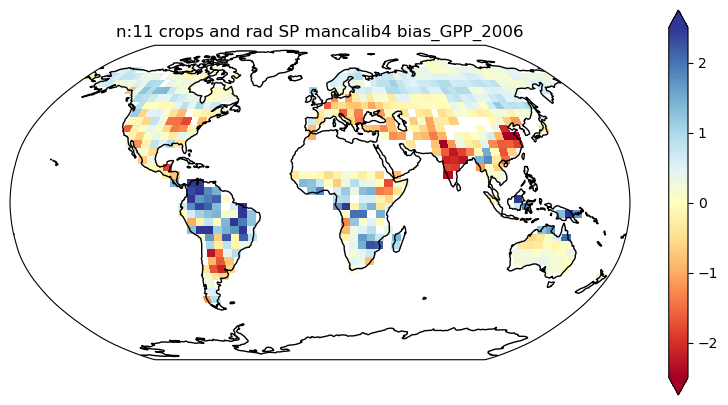

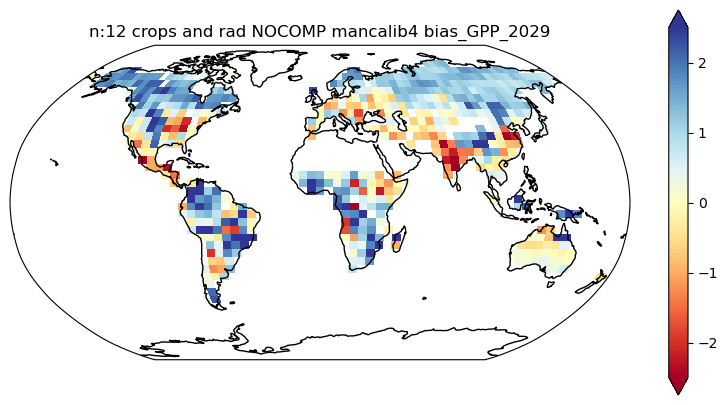

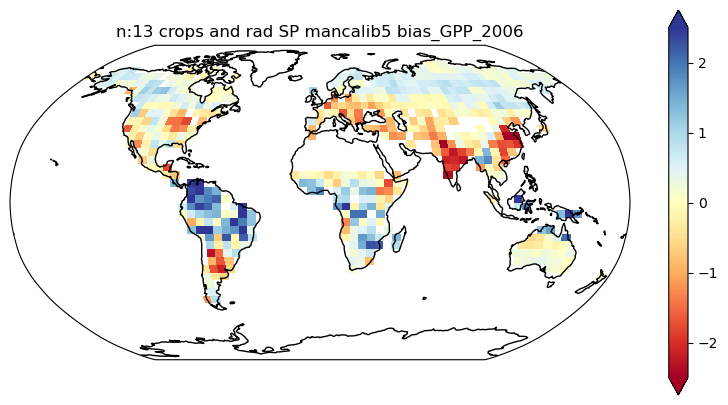

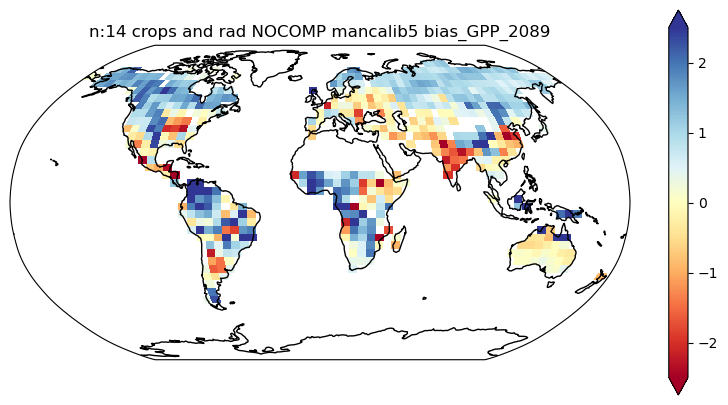

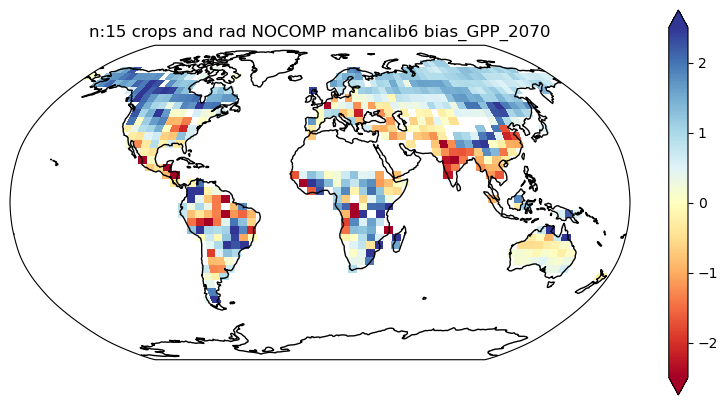

In [84]:
for n in range(nruns):
    bias = ds_out_gpp[n]-gpp45deg
    figname='n:'+str(n)+' '+names[n]+' bias_GPP_'+str(ychoose[n])
    make_bias_plot(bias,figname,-2.5,2.5,n)

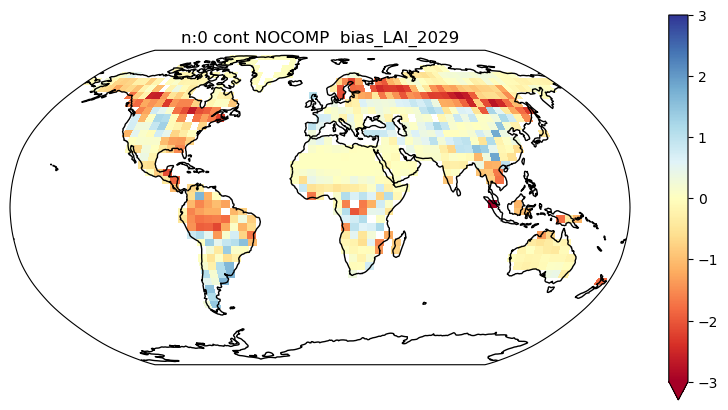

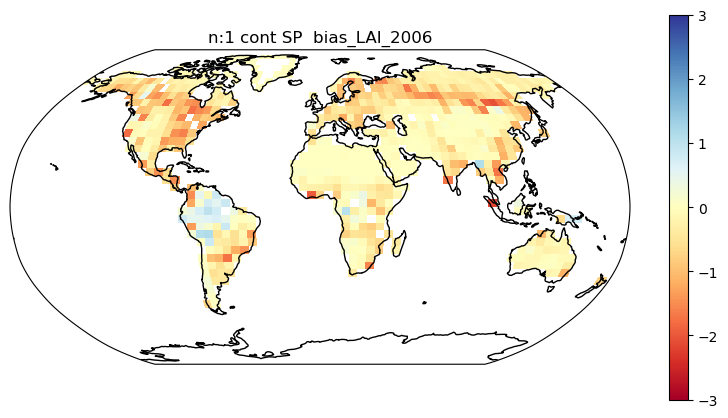

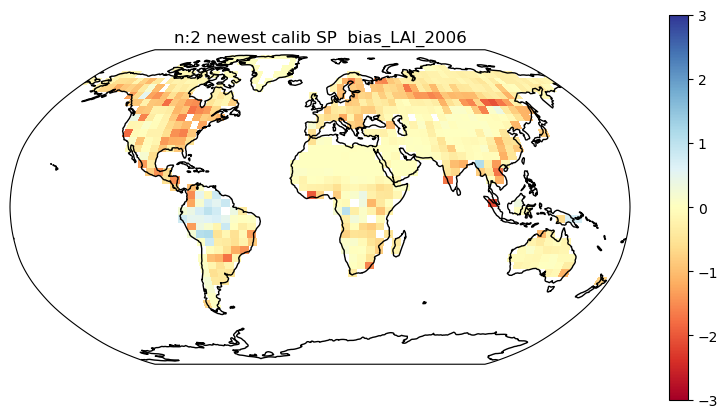

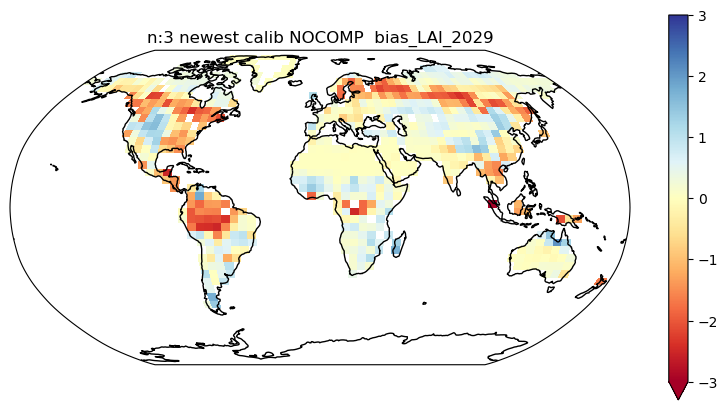

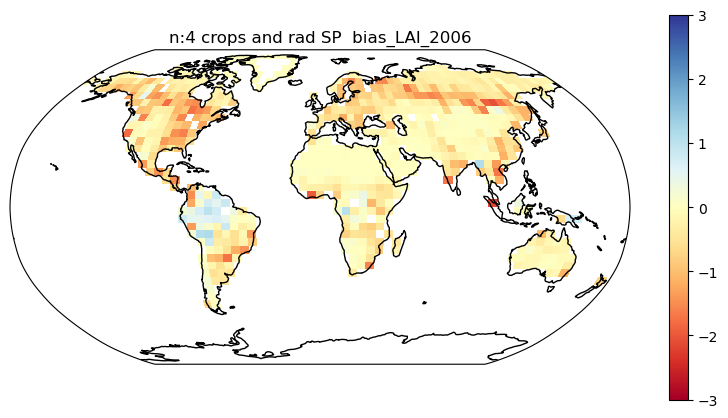

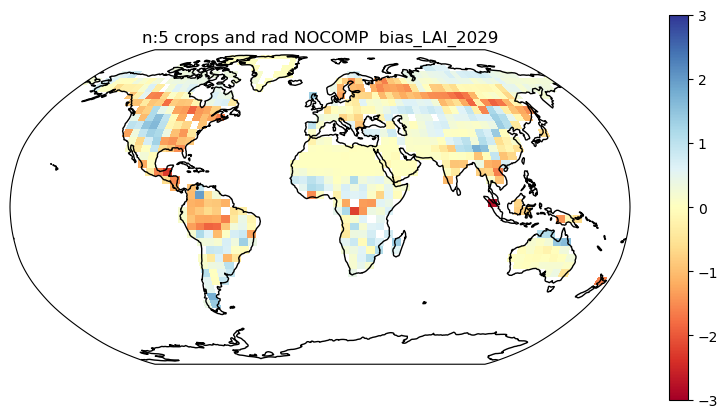

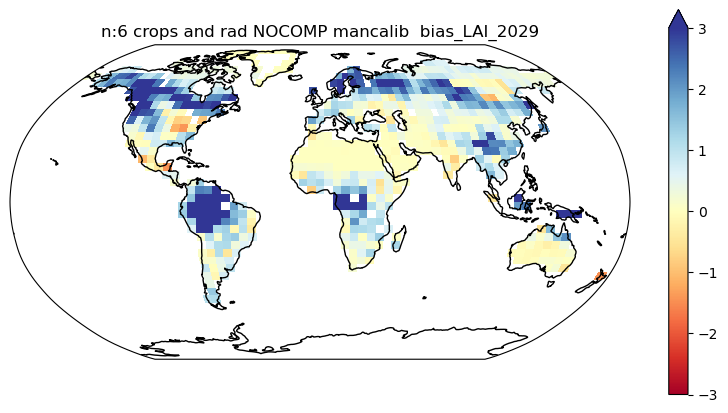

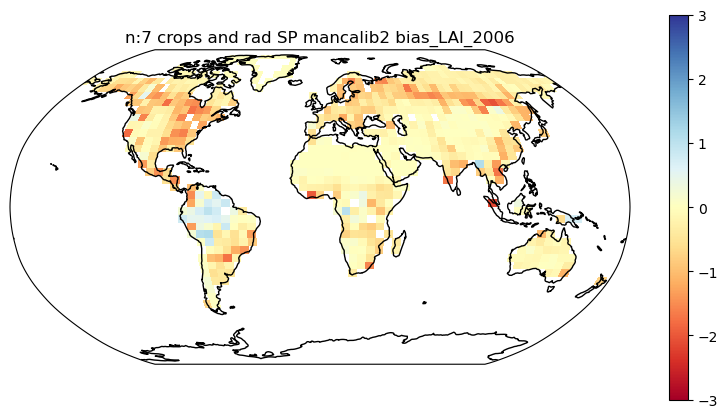

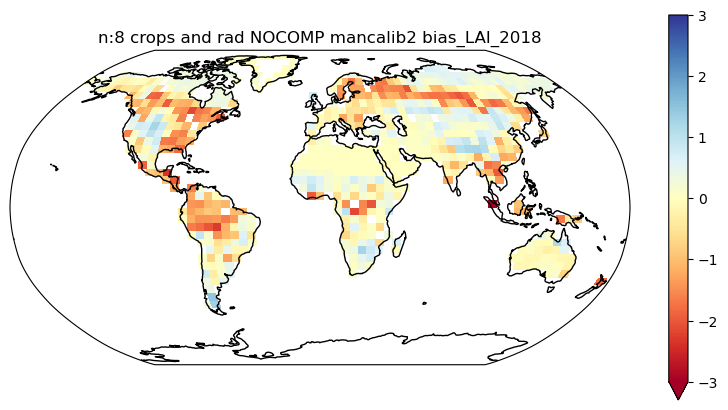

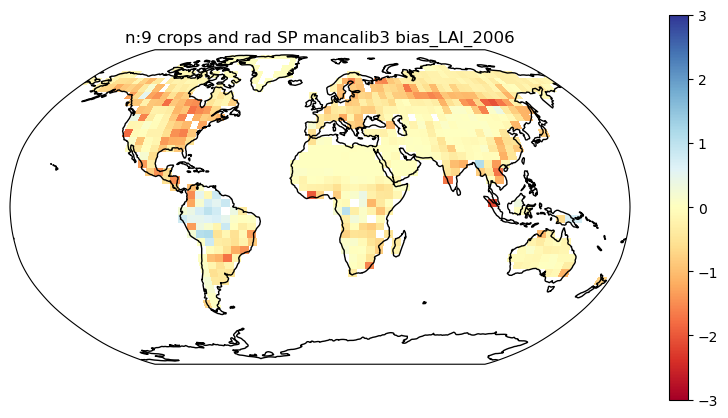

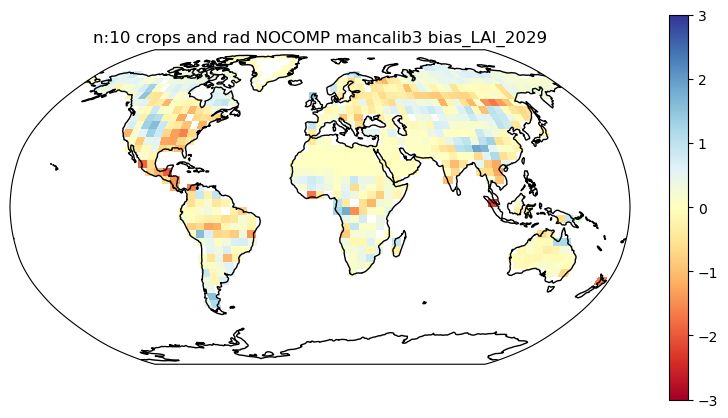

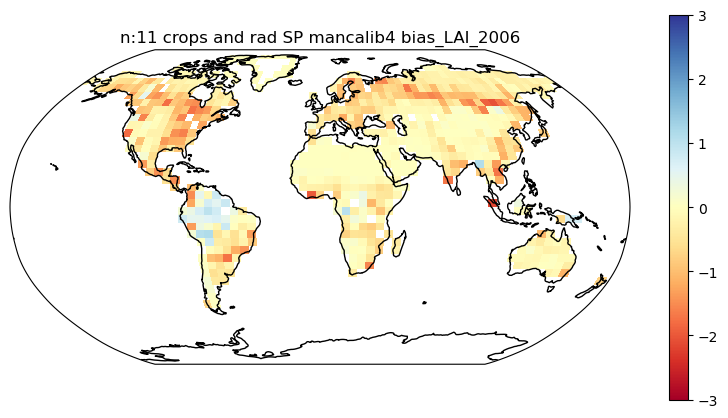

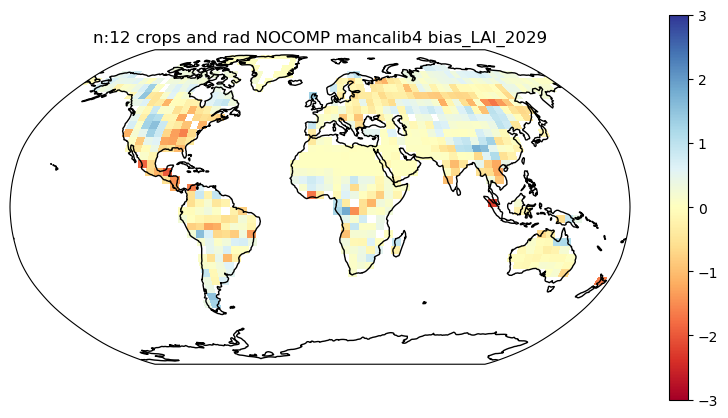

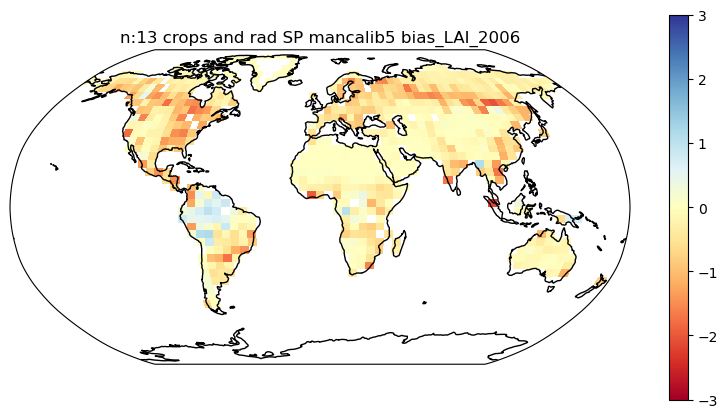

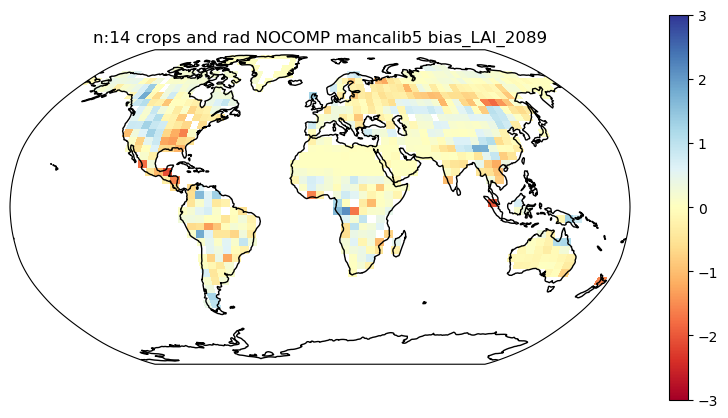

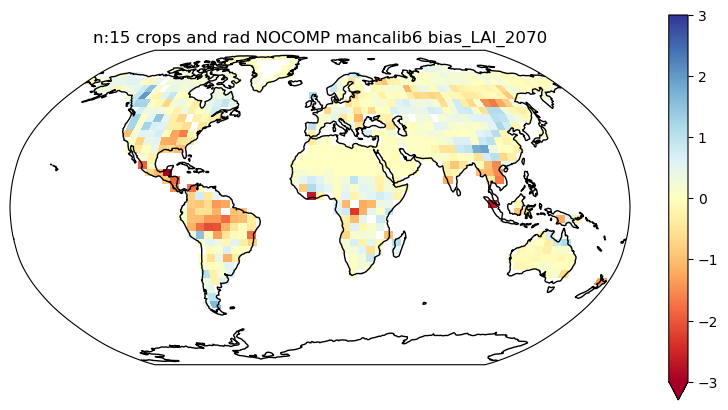

In [85]:
n=1
for n in range(nruns):
    bias = ds_out_lai[n]-lai45deg
    figname='n:'+str(n)+' '+names[n]+' bias_LAI_'+str(ychoose[n])
    make_bias_plot(bias,figname,-3,3,n)

### ABS plots

crops and rad NOCOMP mancalib6abs2070


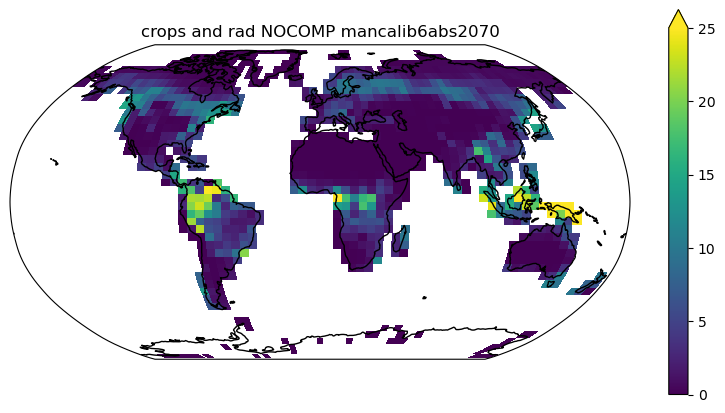

In [106]:
r=15
vegc=output_data[r].FATES_VEGC*output_data[r].FATES_FRACTION
vegc=vegc.mean('time')
figname=names[n]+'abs'+str(ychoose[r])
print(figname)
make_abs_plot(vegc,figname,0,25,n)


### CUE

crops and rad NOCOMP mancalib _CUE_abs2029


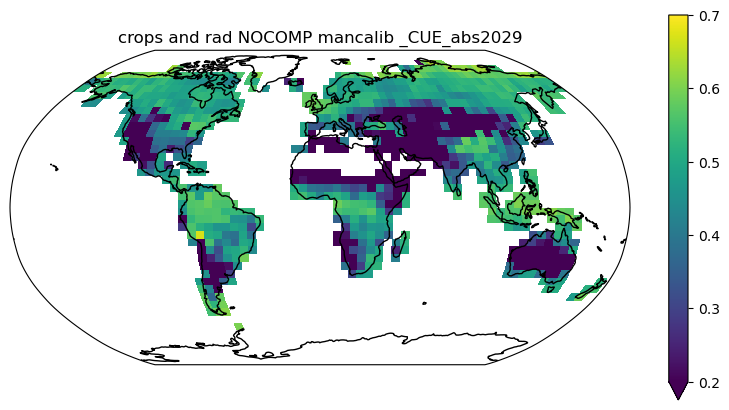

crops and rad NOCOMP mancalib2_CUE_abs2018


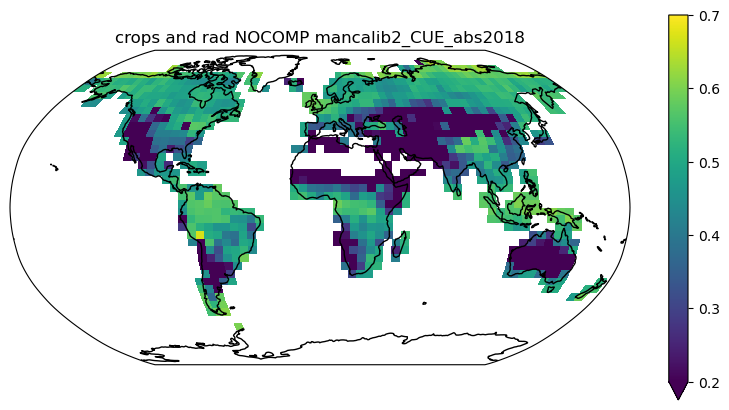

crops and rad NOCOMP mancalib3_CUE_abs2029


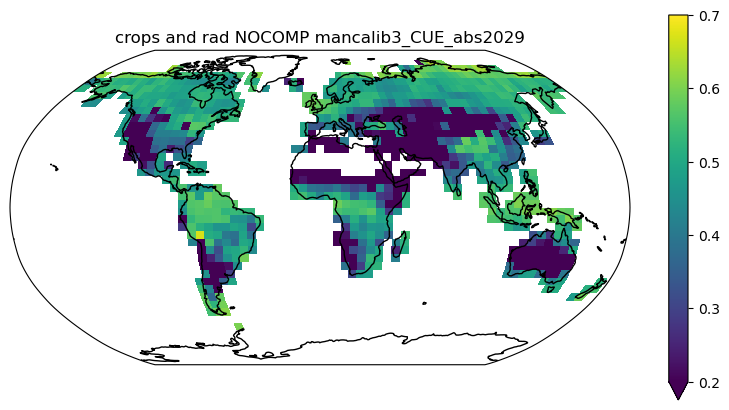

crops and rad NOCOMP mancalib4_CUE_abs2029


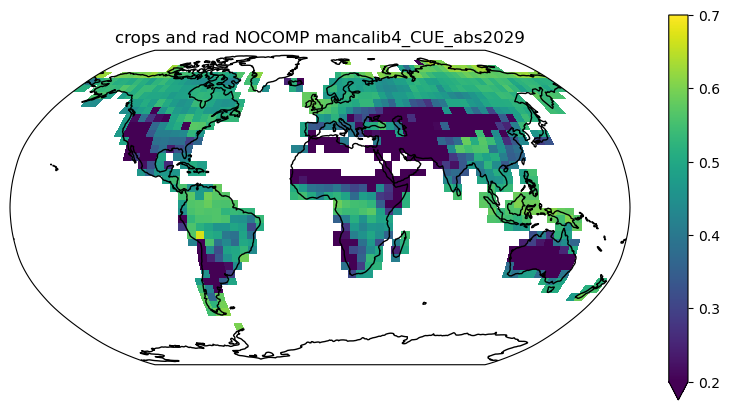

crops and rad NOCOMP mancalib5_CUE_abs2089


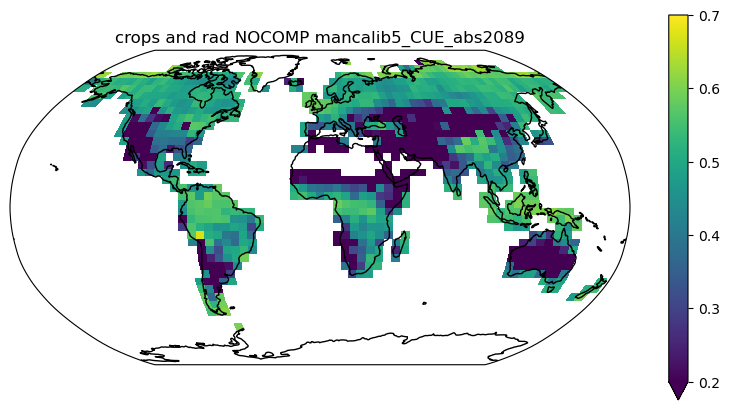

crops and rad NOCOMP mancalib6_CUE_abs2070


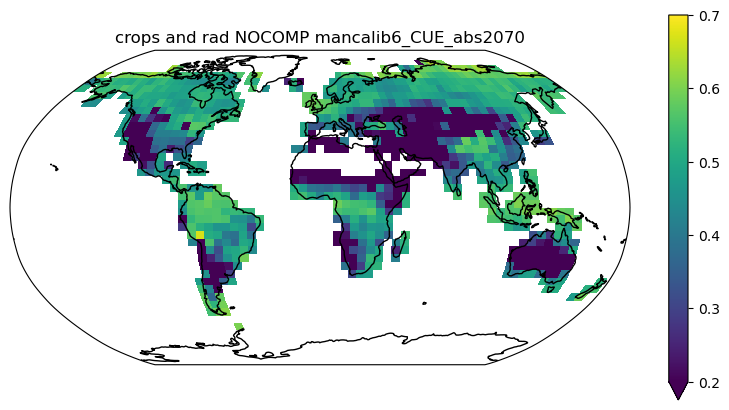

In [87]:

for n in [6,8,10,12,14,15]:
    cue=output_data[r].FATES_NPP.mean('time')/output_data[r].FATES_GPP.mean('time')

    figname=names[n]+'_CUE_abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(cue,figname,0.2,0.7,n)


crops and rad NOCOMP mancalib6diff2070


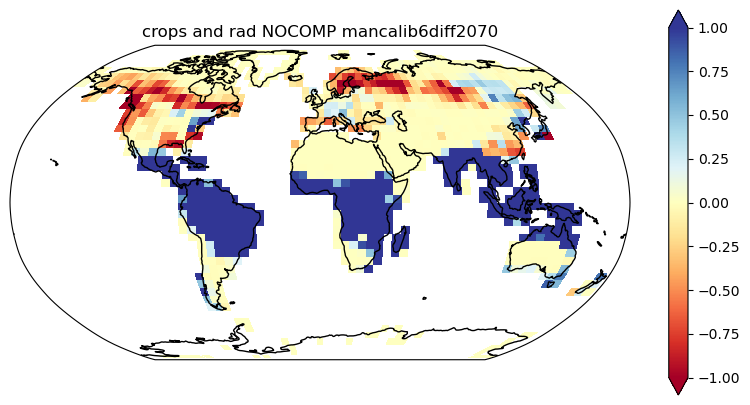

In [88]:
r=14
vegc1=output_data[r].FATES_VEGC*output_data[r].FATES_FRACTION
vegc1=vegc1.mean('time')
r=15
vegc2=output_data[r].FATES_VEGC*output_data[r].FATES_FRACTION
vegc2=vegc2.mean('time')
bias=vegc1-vegc2
figname=names[n]+'diff'+str(ychoose[r])
print(figname)
make_bias_plot(bias,figname,-1,1,n)

crops and rad NOCOMP mancalib6diff2029


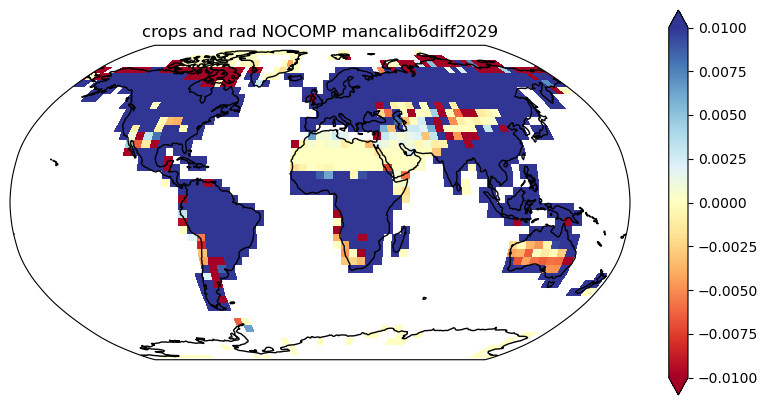

In [89]:
r=14
vegc1=output_data[r].FATES_VEGC*output_data[r].FATES_FRACTION
vegc1=vegc1.mean('time')
r=12

vegc2=output_data[r].FATES_VEGC*output_data[r].FATES_FRACTION
vegc2=vegc2.mean('time')
bias=vegc1-vegc2
figname=names[n]+'diff'+str(ychoose[r])
print(figname)
make_bias_plot(bias,figname,-0.01,0.01,n)

### VEGC

crops and rad NOCOMP mancalib3_vegc_abs2029


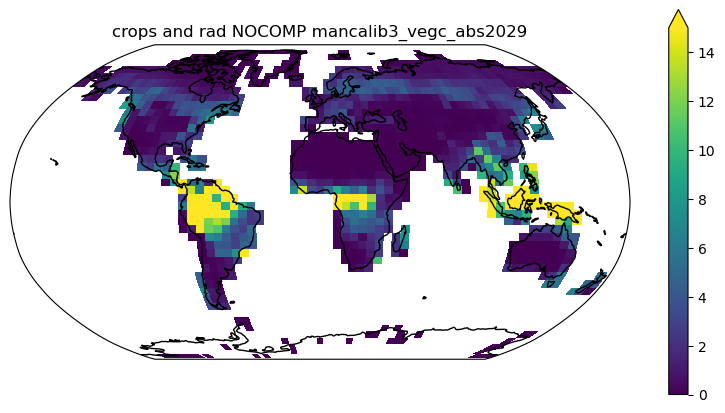

crops and rad NOCOMP mancalib4_vegc_abs2029


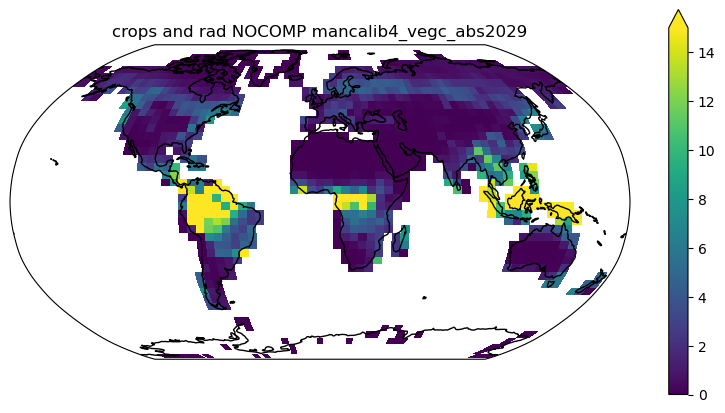

crops and rad NOCOMP mancalib5_vegc_abs2089


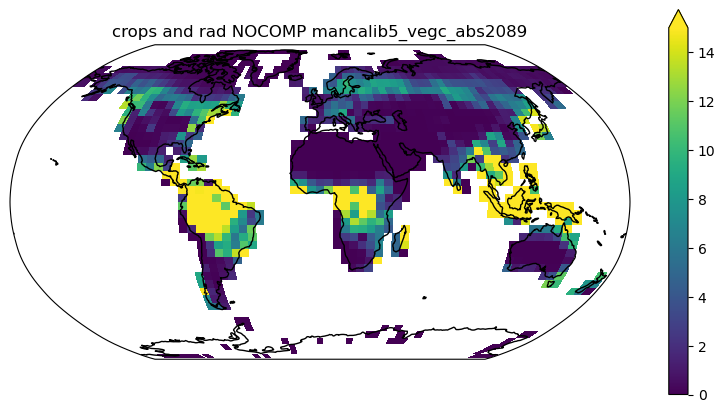

crops and rad NOCOMP mancalib6_vegc_abs2070


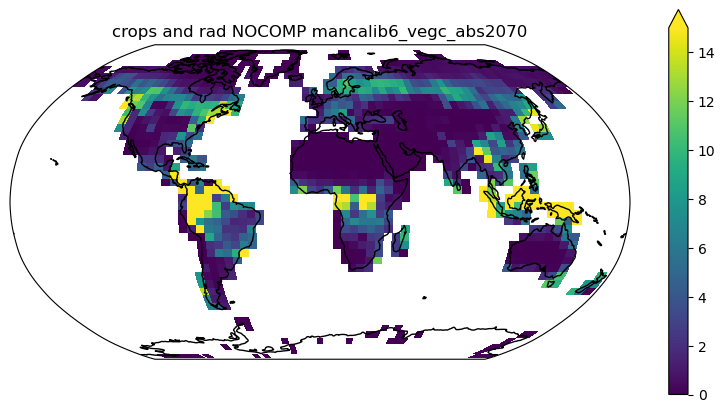

In [112]:

for n in [10,12,14,15]:
    vegc=output_data[n].FATES_VEGC*output_data[n].FATES_FRACTION
    vegc=vegc.mean('time')
    figname=names[n]+'_vegc_abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(vegc,figname,0,15,n)

### NPP

crops and rad NOCOMP mancalib3_npp_abs2029


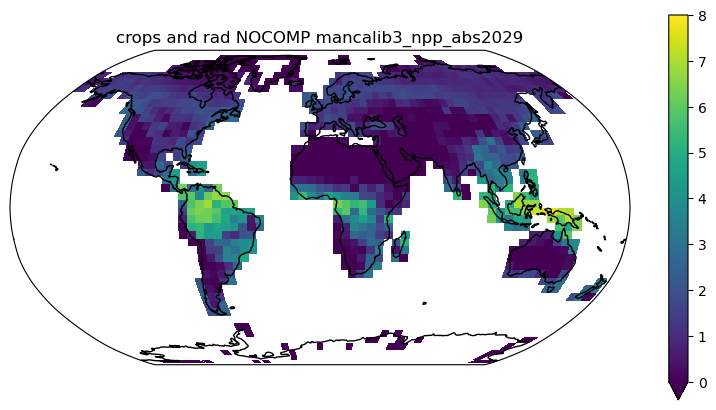

crops and rad NOCOMP mancalib4_npp_abs2029


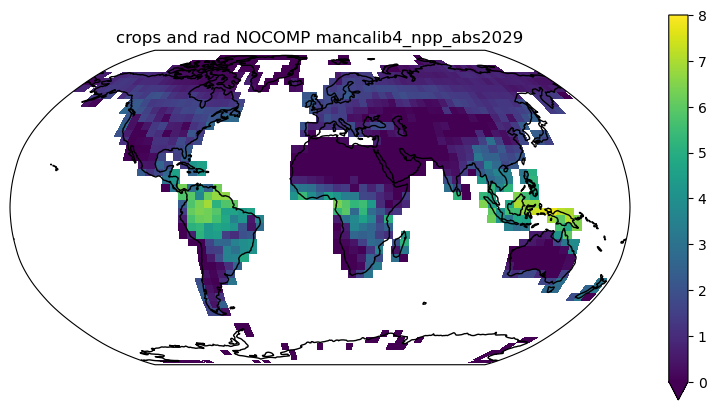

crops and rad NOCOMP mancalib5_npp_abs2089


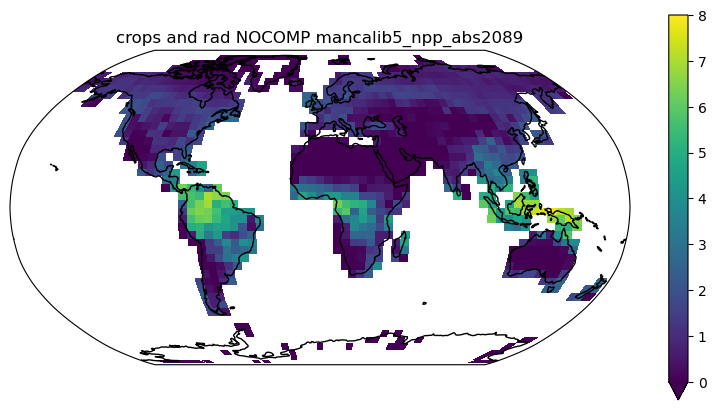

crops and rad NOCOMP mancalib6_npp_abs2070


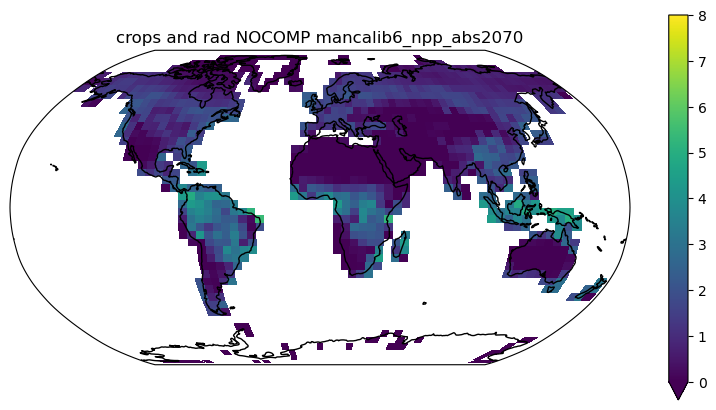

In [107]:
for n in [10,12,14,15]:
    npp=output_data[n].FATES_NPP*output_data[n].FATES_FRACTION
    npp=npp.mean('time')*3600*24*1000
    figname=names[n]+'_npp_abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(npp,figname,0,8,n)

In [109]:
for n in [10,12,14,15]:
    vegc=output_data[n].FATES_VEGC*output_data[n].FATES_FRACTION
    
    figname=names[n]+'_vegc_abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(vegc,figname,0,28,n)

crops and rad NOCOMP mancalib3_vegc_abs2029


AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

crops and rad NOCOMP mancalib3_npp_abs2029


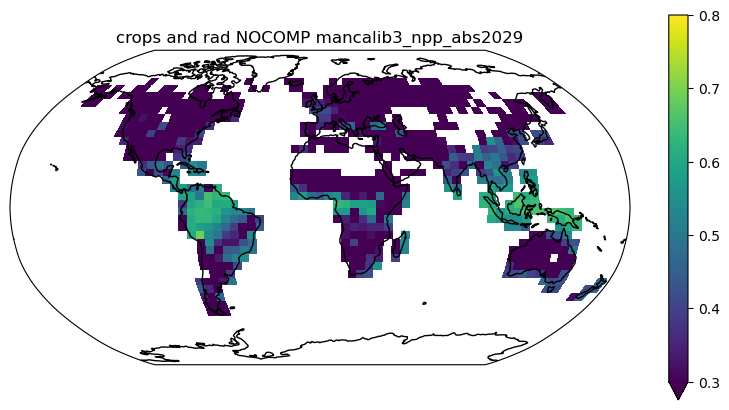

crops and rad NOCOMP mancalib4_npp_abs2029


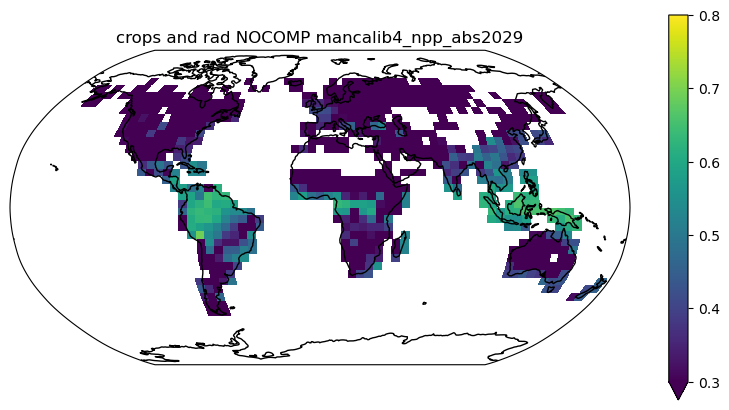

crops and rad NOCOMP mancalib5_npp_abs2089


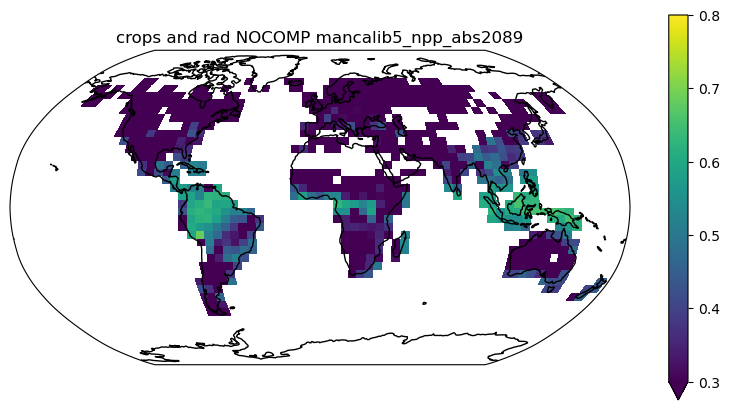

crops and rad NOCOMP mancalib6_npp_abs2070


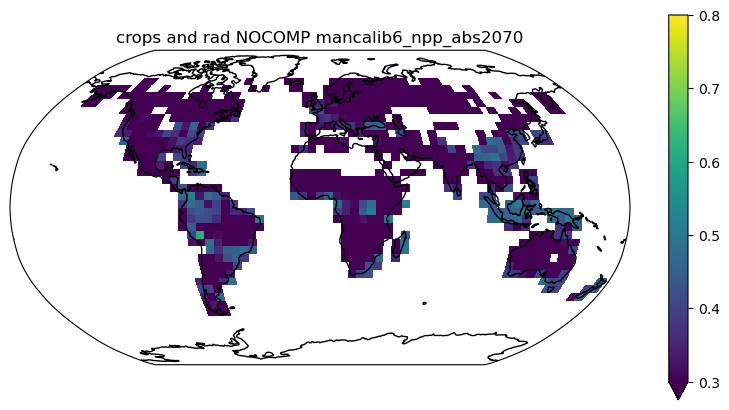

In [108]:
for n in [10,12,14,15]:
    cue=output_data[n].FATES_NPP/output_data[n].FATES_GPP
    cue=cue.mean('time')
    figname=names[n]+'_npp_abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(cue,figname,0.3,0.8,n)

cont NOCOMP abs2029


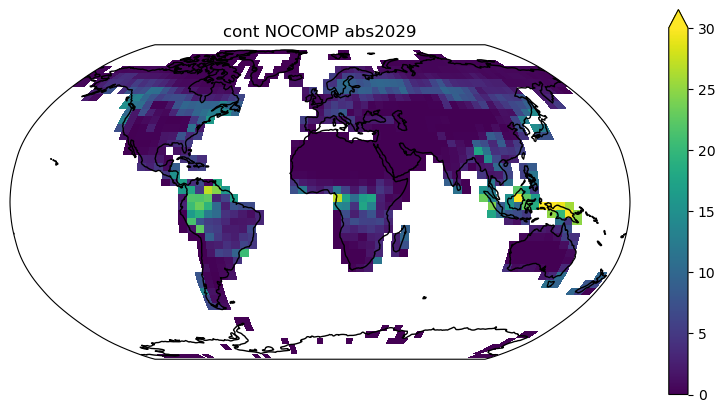

cont SP abs2006


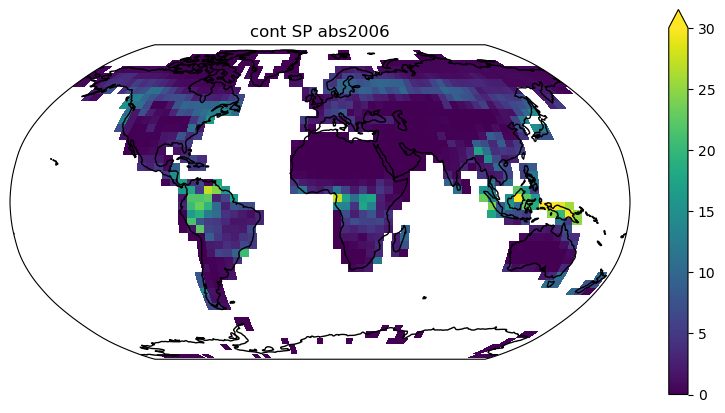

newest calib SP abs2006


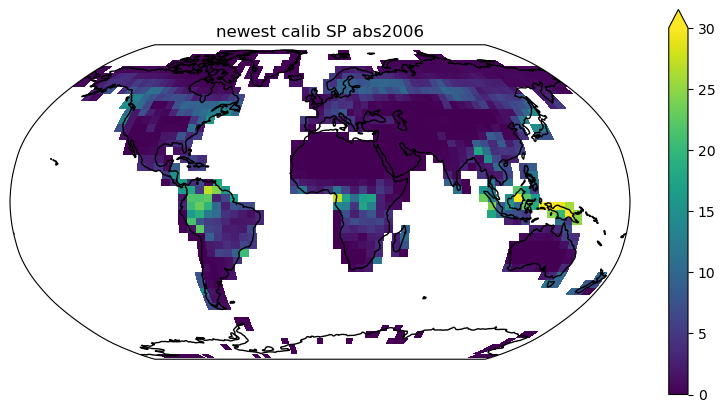

newest calib NOCOMP abs2029


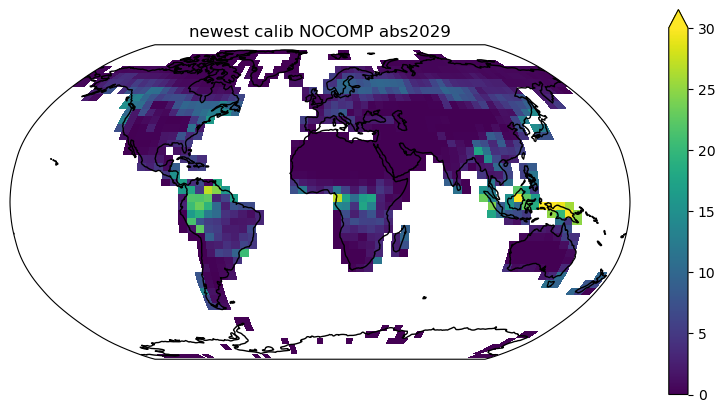

crops and rad SP abs2006


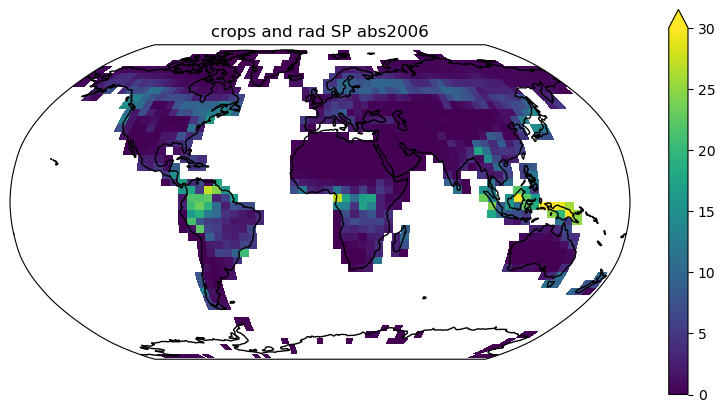

crops and rad NOCOMP abs2029


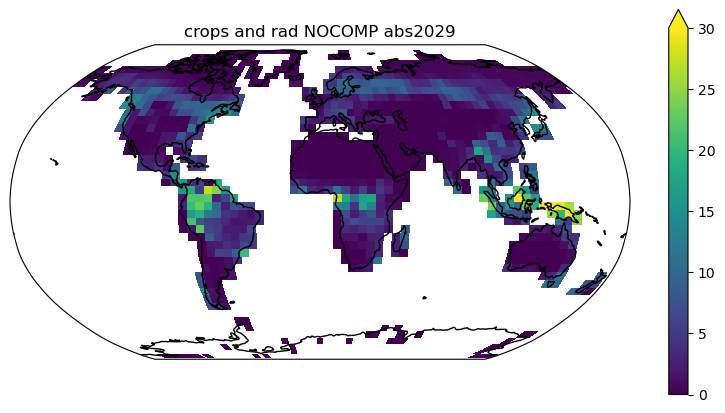

crops and rad NOCOMP mancalib abs2029


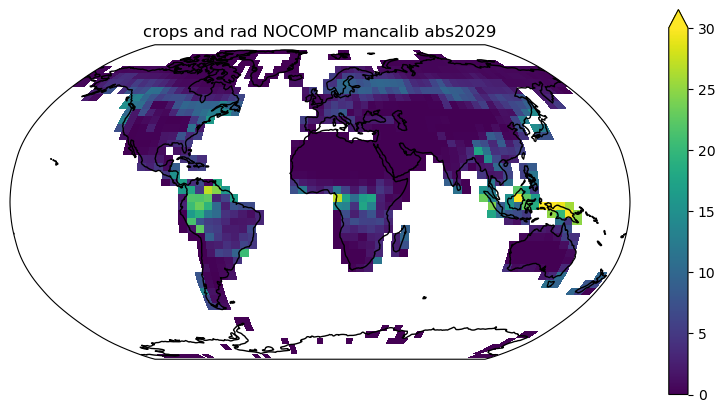

crops and rad SP mancalib2abs2006


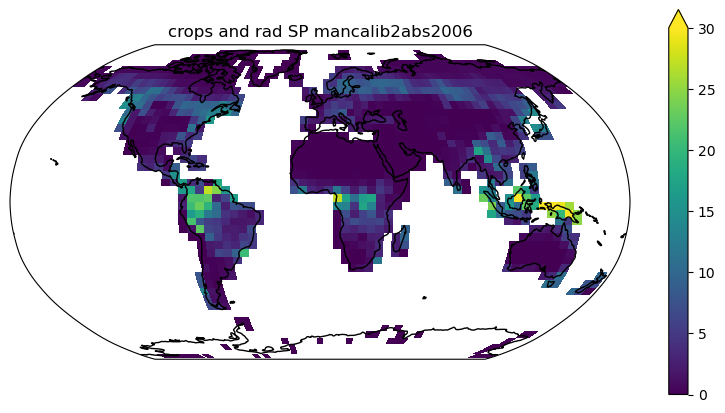

crops and rad NOCOMP mancalib2abs2018


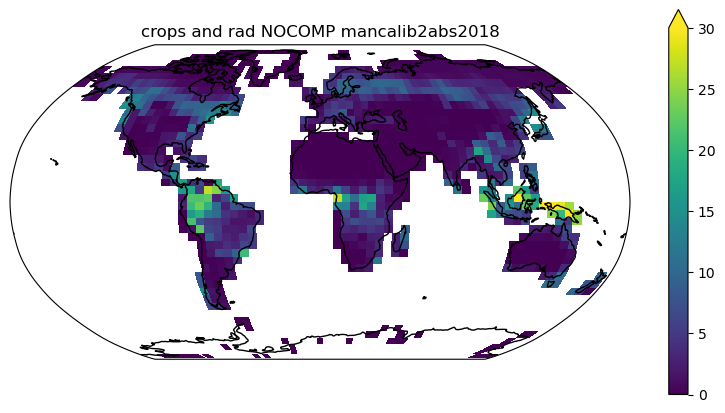

crops and rad SP mancalib3abs2006


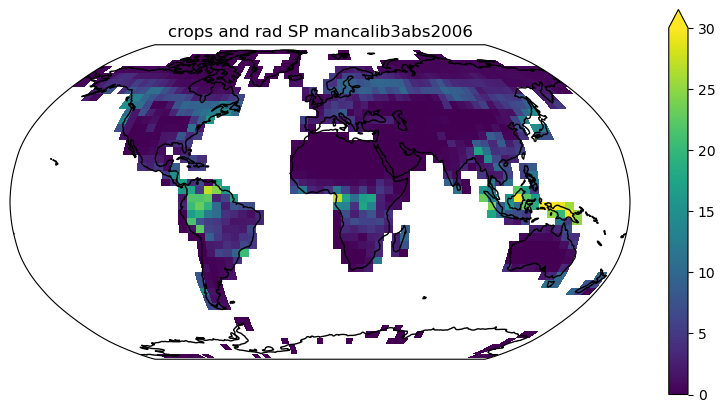

crops and rad NOCOMP mancalib3abs2029


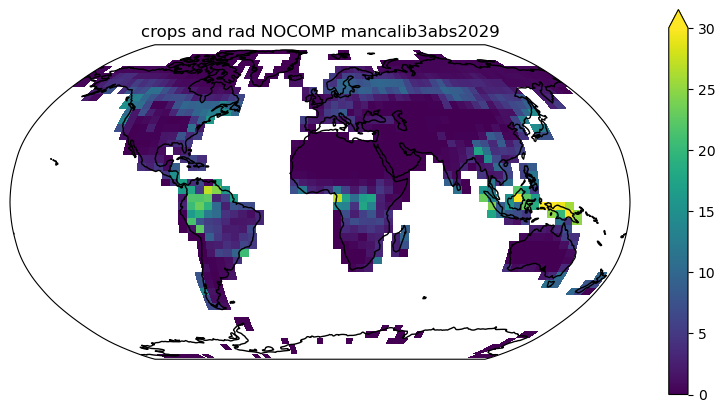

crops and rad SP mancalib4abs2006


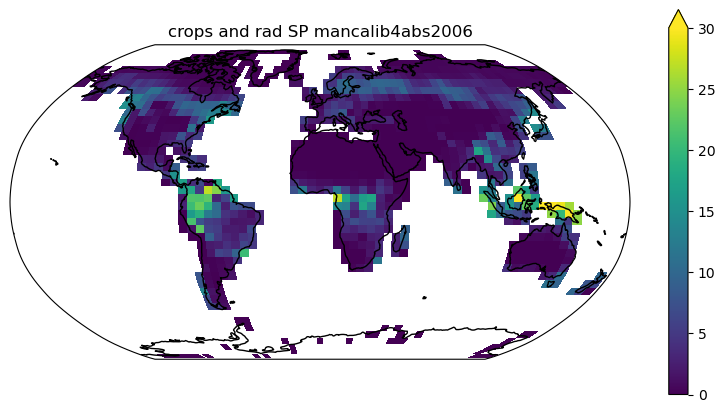

crops and rad NOCOMP mancalib4abs2029


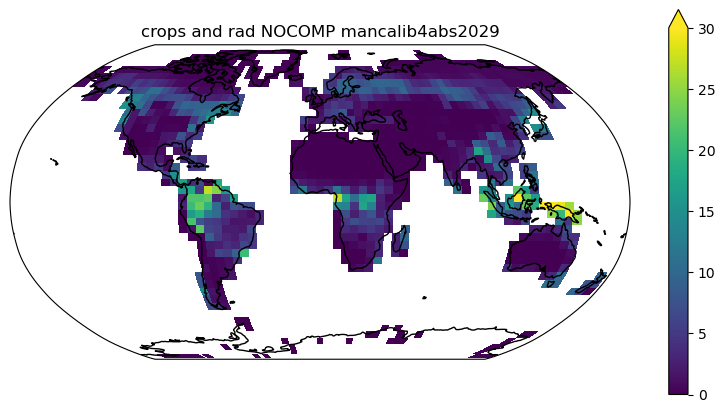

crops and rad SP mancalib5abs2006


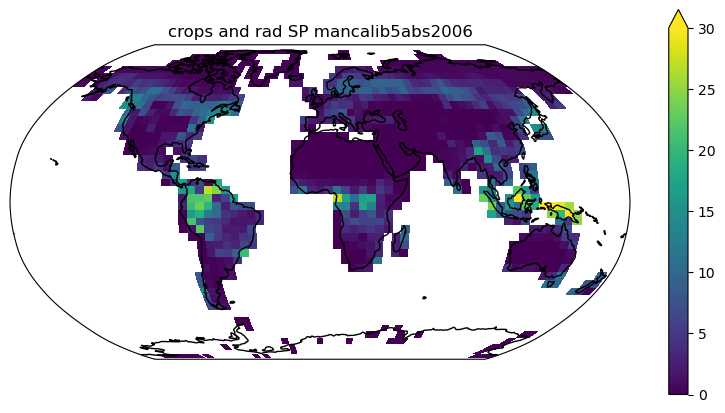

crops and rad NOCOMP mancalib5abs2089


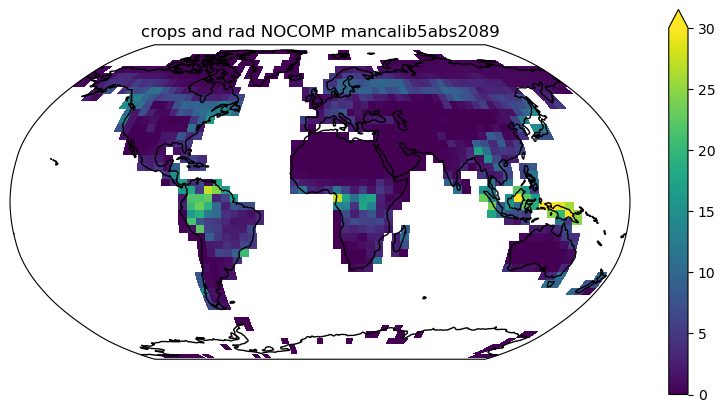

crops and rad NOCOMP mancalib6abs2070


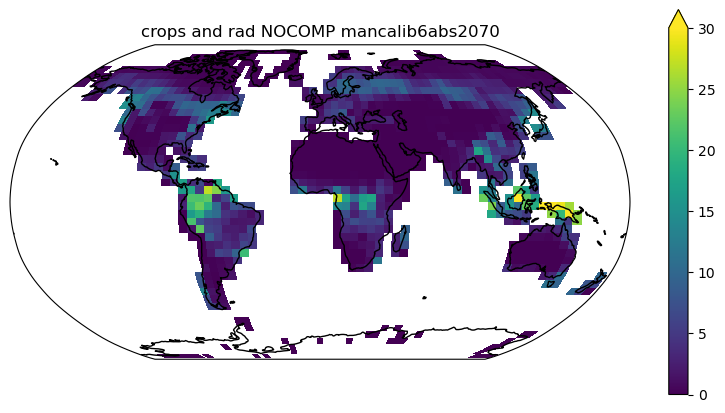

In [103]:

for n in range(nruns):
    abs = ds_out_gpp[n]
    figname=names[n]+'abs'+str(ychoose[n])
    print(figname)
    make_abs_plot(vegc,figname,0,30,n)


In [94]:
p1='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/intermediate_pfiles/fates_params_vertsc_dayl_SPcal_4.nc'

In [95]:
p2='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/SP_LHC//sp_lhc_v1_40.nc'

In [96]:
p1d=xr.open_dataset(p1)
p2d=xr.open_dataset(p1)

In [97]:
ds1 = xr.open_dataset(p1)
ds2 = xr.open_dataset(p2)

# Loop through the variables and compare them
for var in ds1.variables:
    if var in ds2.variables:
        if not ds1[var].equals(ds2[var]):
            print(f"Differences found in variable {var}")
            print('calib',ds1[var].values)
            print('pftsg',ds2[var].values)
    else:
        print(f"Variable {var} not found in {file2}")

# Check for variables in file2 that are not in file1
for var in ds2.variables:
    if var not in ds1.variables:
        print(f"Variable {var} not found in {file1}")

# Close the datasets
ds1.close()
ds2.close()

Differences found in variable fates_alloc_storage_cushion
calib [1.2 1.2 1.2 1.2 2.4 1.2 1.2 2.4 1.2 1.2 1.2 1.2]
pftsg [1.2 2.4 2.4 1.2 2.4 2.4 2.4 2.4 2.4 2.4 2.4 2.4]
Differences found in variable fates_leaf_jmaxse
calib [544.98760814 437.10191078 465.4758702  495.         495.
 495.         495.         495.         495.         468.73443032
 470.99515046 496.6696605 ]
pftsg [495. 495. 495. 495. 495. 495. 495. 495. 495. 495. 495. 495.]
Differences found in variable fates_leaf_stomatal_intercept
calib [  5666.85391194  33315.31798552 111020.66103126  10000.
  10000.          10000.          10000.          10000.
  10000.          97325.08415266  59522.97607906 110976.8114589 ]
pftsg [180000.1 180000.1 180000.1 180000.1 180000.1 180000.1 180000.1 180000.1
 180000.1 180000.1 180000.1 180000.1]
Differences found in variable fates_leaf_stomatal_slope_ballberry
calib [ 8.92503038  9.03051088 10.02428366 12.3        13.1        13.1
 13.8        13.8        13.8         9.50769864  9.503

In [98]:
pfile='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/parameter_outputs/manual_nocomp_calibration_04july.nc'

pf=xr.open_dataset(pfile)

pf.fates_maintresp_leaf_model.values

array(2.)

In [99]:
pf.fates_recruit_seed_supplement.values

array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75])

In [100]:
pf.fates_maintresp_leaf_vert_scaler_coeff2.values

array([1.5 , 1.5 , 2.25, 2.43, 2.43, 2.43, 2.43, 2.43, 2.43, 2.43, 2.25,
       2.25])

In [101]:
pf.fates_stoich_nitr.values

array([[3.3e-02, 2.9e-02, 4.0e-02, 3.3e-02, 4.0e-02, 4.0e-02, 3.3e-02,
        4.0e-02, 4.0e-02, 4.0e-02, 4.0e-02, 4.0e-02],
       [2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02,
        2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02],
       [1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08,
        1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08],
       [4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03,
        4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03]])